In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import scipy
from sklearn import preprocessing

%matplotlib inline

In [31]:
# # Get in dataset
# data_features_test = pd.read_csv("/home/knel/virtual_envs/ankh-morpork/ICS_data_generation/data/csvDataFeaturesTest.csv", sep=";")

# # Take out only data corresponing to attacks and remove the column labelling it as an attack
# data_features_attacks = data_features_test.to_numpy()[238279:, :-1]
# print(np.count_nonzero(np.isnan(data_features_attacks)))
# # Set negative values to 0
# data_features_attacks = np.where(data_features_attacks >= 0, data_features_attacks, 0)
# data_features_attacks = data_features_attacks.reshape((9999,21,1)).astype('float32')

In [32]:
attacks = pd.read_csv("/home/knel/virtual_envs/ankh-morpork/ICS_data_generation/data/wustl_attacks.csv", sep=",")

In [33]:
attacks = preprocessing.normalize(attacks.to_numpy()[:, 1:], norm="max", axis=0)

# swap sport to front
# attacks[:, [0, 1]] = attacks[:, [1, 0]]
# # swap dport to after sport
# attacks[:, [1, 2]] = attacks[:, [2, 1]]
# # swap protocols to after dport
# attacks[:, [2, 14]] = attacks[:, [14, 2]]

# column order now -> sport, dport, protocols, continuous (discrete, discrete, discrete, continuous)

In [34]:
# what is sequence length actually representing here
# time steps
seq_length = 10
batch_size = 64
features = attacks.shape[1]
latent_dim = 100

In [35]:
attacks.shape

(87016, 27)

In [36]:
# shuffle prevents model from getting stuck in local minima when solving the loss function
# train_dataset = attacks[:20000]
train_dataset = (tf.data.Dataset.from_tensor_slices(attacks[:9984]).shuffle(10000).batch(batch_size))
# test_dataset = attacks[int(np.floor(attacks.shape[0]*3/4)):]
test_dataset = attacks[attacks.shape[0]-3000:]

In [37]:
def make_generator_model():
    model = tf.keras.Sequential()
    # LSTM hidden layer with 100 memory units
    model.add(tf.keras.layers.LSTM(200, input_shape = (seq_length, latent_dim), recurrent_dropout=0.4, return_sequences=True))
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.LSTM(200, recurrent_dropout=0.4))
    model.add(tf.keras.layers.ReLU())
    # dropout layer with a probability of 20
    # model.add(tf.keras.layers.Dropout(0.2))
    # output dense (fully connected) layer
    model.add(tf.keras.layers.Dense(features, activation="sigmoid"))
    return model

In [38]:
generator = make_generator_model()
# what do we want to the generator to output? One packet at a time? One attack at a time?
# what to use as noise - what kind of dimension?
# BGAN does [batch_size x seq_length, features]
# LSTM expects sequences of the form [samples, time steps, features]
# noise = tf.random.normal((batch_size, seq_length, features))
# generated_data_untrained = generator(noise, training=False)
# generated_data_untrained.get_shape()

In [39]:
test_dataset[0]

array([4.78530229e-01, 1.22096395e-03, 2.92112950e-03, 0.00000000e+00,
       4.00480577e-04, 1.98196413e-04, 3.65144055e-04, 2.98095640e-06,
       8.73414451e-06, 8.73414451e-06, 1.07063700e-05, 1.07063700e-05,
       1.90023753e-03, 7.98722045e-04, 1.00000000e+00, 2.64192928e-02,
       9.34084823e-03, 5.49079570e-02, 9.99940251e-01, 5.49079570e-02,
       5.49079570e-02, 5.49079570e-02, 8.98039216e-01, 0.00000000e+00,
       0.00000000e+00, 5.49079570e-02, 2.64192928e-02])

In [40]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(200, input_shape=(features,1), recurrent_dropout=0.4, return_sequences=True))
    model.add(tf.keras.layers.LSTM(200, recurrent_dropout=0.4))
    # model.add(tf.keras.layers.Dropout(0.2))
    # what should the units of this dense layer be?
    # seems like it outputs one value >0 for real data and <0 for fake data
    # for each item in the batch
    model.add(tf.keras.layers.Dense(1, activation="tanh"))
    return model

In [41]:
discriminator = make_discriminator_model()
# decision_untrained = discriminator(generated_data_untrained)
# decision_untrained

### Binary Cross Entropy

$$ H_p(q) = -\frac{1}{N} \Sigma_{i=1}^N y_i log(p(y_i)) + (1-y_i) log(1-p(y_i)) $$

### BGAN Losses

$$ D_{loss} = \frac{1}{m} \Sigma_{i=1}^m [logD(x_i) + log(1-D(G(z_i)))] $$

$$ G_{loss} = \frac{1}{m} \Sigma_{i=1}^m [log(1-D(G(z_i)))] $$

In [42]:
# define losses (this will change)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False) # from_logits=True means models prediction represents a value [-inf, inf]

In [43]:
def discriminator_loss(real_data, fake_data):
    real_loss = cross_entropy(tf.ones_like(real_data), real_data)
    fake_loss = cross_entropy(tf.zeros_like(fake_data), fake_data)
    total_loss = real_loss + fake_loss
    return total_loss

    # BGAN loss
    # loss = tf.reduce_mean(tf.math.log(real_data) + tf.math.log(1 - fake_data))
    # # if tf.math.is_nan(loss):
    # #     return 0.0
    # return loss

In [44]:
d = discriminator(attacks[:64])
# tf.math.log(d), d

In [45]:
def generator_loss(fake_data):
    # return cross_entropy(tf.ones_like(fake_data), fake_data)

    # BGAN loss
    loss = tf.reduce_mean(tf.math.log(1 - fake_data))
    return loss

In [46]:
generator_optimiser = tf.keras.optimizers.Adam(1e-4)
discriminator_optimiser = tf.keras.optimizers.Adam(1e-4)

In [47]:
@tf.function
def train_step(data):
    dlosses = []
    glosses = []
    # generate samples from the random space
    noise = tf.random.normal((batch_size, seq_length, latent_dim))

    with tf.GradientTape() as generator_tape, tf.GradientTape() as discriminator_tape:
        generated_data = generator(noise, training=True)

        real_data = discriminator(data, training=True)
        fake_data = discriminator(generated_data, training=True)

        gloss = generator_loss(fake_data)
        dloss = discriminator_loss(real_data, fake_data)
        dlosses.append(dloss)
        glosses.append(gloss)

    generator_gradients = generator_tape.gradient(gloss, generator.trainable_variables)
    discriminator_gradients = discriminator_tape.gradient(dloss, discriminator.trainable_variables)

    generator_optimiser.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimiser.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))
    return dloss, gloss

In [48]:
epochs = 50

In [49]:
def train(dataset, epochs):
    dlosses = []
    glosses = []

    for epoch in range(epochs):
        
        # maybe add another loop for more training rounds
        for data_batch in dataset:
            dloss, gloss = train_step(data_batch)
        dlosses.append(dloss)
        glosses.append(gloss)

    return dlosses, glosses

In [50]:
# 33m to run 50 epochs with 20000 data points
dlosses, glosses = train(train_dataset, epochs=epochs)

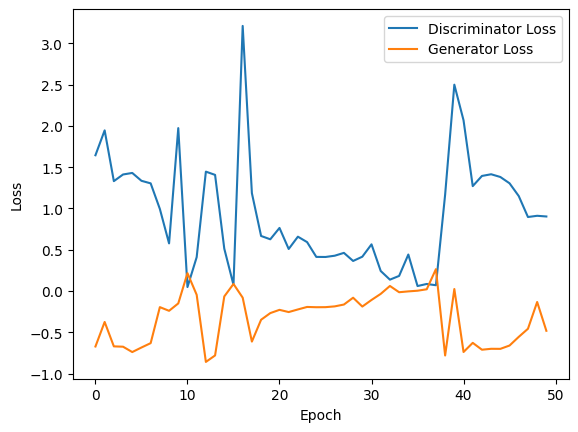

In [58]:
plt.plot(dlosses, label="Discriminator Loss")
plt.plot(glosses, label="Generator Loss")
# plt.ylim(-1,2)
# plt.xlim(0, 41)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
# plt.savefig("gan_lstm_swat_sensor_2.png", dpi=800)

In [52]:
# when I increase memory units the losses go wild
# smoother losses using tanh for both activations and non-logit binary crossentropy
# not adding dropout genuinely makes it go insane

In [53]:
test_noise = tf.random.normal((test_dataset.shape[0], seq_length, latent_dim))
test_noise.shape
preds = generator.predict(test_noise)

94/94 [==============================] - 1s 3ms/step


In [54]:
preds.shape

(3000, 27)

In [59]:
# df = pd.DataFrame(preds)
# df.to_csv("gan_lstm_wustl.csv", index=False)

In [56]:
scipy.stats.ks_2samp(test_dataset.reshape(preds.shape[0]*features,), preds.reshape(preds.shape[0]*features,))

KstestResult(statistic=0.6331481481481481, pvalue=0.0, statistic_location=0.011013215859030838, statistic_sign=1)

In [57]:
preds[0], test_dataset[0]

(array([0.32421285, 0.05682771, 0.03788305, 0.09298382, 0.53382075,
        0.19721803, 0.04292379, 0.0181184 , 0.01909317, 0.02828927,
        0.01884129, 0.01215813, 0.05579174, 0.0137105 , 0.01293292,
        0.16495739, 0.2437218 , 0.6613826 , 0.67537224, 0.68599045,
        0.17586604, 0.5471013 , 0.49870262, 0.55604047, 0.8224627 ,
        0.24067844, 0.7981756 ], dtype=float32),
 array([4.78530229e-01, 1.22096395e-03, 2.92112950e-03, 0.00000000e+00,
        4.00480577e-04, 1.98196413e-04, 3.65144055e-04, 2.98095640e-06,
        8.73414451e-06, 8.73414451e-06, 1.07063700e-05, 1.07063700e-05,
        1.90023753e-03, 7.98722045e-04, 1.00000000e+00, 2.64192928e-02,
        9.34084823e-03, 5.49079570e-02, 9.99940251e-01, 5.49079570e-02,
        5.49079570e-02, 5.49079570e-02, 8.98039216e-01, 0.00000000e+00,
        0.00000000e+00, 5.49079570e-02, 2.64192928e-02]))